In [1]:
#@title Installation der Softwarepakete
%%capture
#                 Utility-tool for monitoring Nvidia-GPUs (debugging-purposes)
!nvidia-smi
#                 Library for Stable Diffusion modells
!pip install diffusers
# transformers:   Library for Transformer modells
# scipy:          Library for highly optimised algorithms (scientific computing)
# ftfy:           Library for fixing issues in Unicode-inputs (heuristic)
# accelerate:     Library for abstracting various system hardware environments (local, cloud, single CPU, multi-GPU, TPU, etc...)
!pip install transformers scipy ftfy accelerate

#                 StableDiffusionPipeline can load the model and persist it in an object for future access
from diffusers import StableDiffusionPipeline
#                 Torch is the utilized "lowlevel" ML-Library
import torch

# model_id contains the name of the desired model to use
model_id = "XpucT/Deliberate"

# the model is loaded into the pipe-object with float16 precision
pipe = StableDiffusionPipeline.from_pretrained(model_id, torch_dtype=torch.float16)

# the modell uses GPU ("cuda" is the Nvidia-API)
pipe = pipe.to("cuda")

# utilize a second model for "editing" a generated picture more precisely
from diffusers import StableDiffusionInstructPix2PixPipeline, EulerAncestralDiscreteScheduler
model_id = "timbrooks/instruct-pix2pix"
editing_pipe = StableDiffusionInstructPix2PixPipeline.from_pretrained(model_id, torch_dtype=torch.float16, revision="fp16", safety_checker=None)
editing_pipe.to("cuda")
editing_pipe.enable_attention_slicing()

## Nachfolgend kannst du der KI Anweisungen geben wie Sie dein Wunschbild soll.

### Hinweis 1:
****
Gib deinen *Prompt* möglichst in, mit Komma voneinander getrennten, Stichworten an.

**Beispiel:** "superhero, time-travel, teenager, cool"

### Hinweis 2:
****
Dieses Modell funktioniert am besten wenn die Prompts auf Englisch geschrieben werden. Falls du Hilfe brauchst, melde dich einfach!

### Hinweis 3:
****

**Hier sind ein paar Prompt Beispiele:** <br>
(Ersetze den Begriff der als Platzhalter in den eckigen Klammern steht, mit dem was du möchtest und entferne die eckigen Klammern.)


1. [superpower*], teenager girl, super power, drawing, artwork, fantasy hero character portrait *(z.B. Firestarter, Plant Whisperer, Wind Rider usw.)
2. steampunk city, christmas, sunset, photorealism, from above
3. japan street, night, raining, moonlight, high detail, anime style
4. mystical forest, vibrant colors, towering trees, magical creatures
5. dramatic battle between elemental forces, with fire, water, earth, and air colliding in a mesmerizing display of power and energy
6. [game*] game styled character, less realistic, stunning background *(z.B. League of Legends, GTA 5, Fortnite usw.)
7.

### Hinweis 4:
****

Der "**Positive Prompt**" sagt der KI was es in dem Bild generieren soll, der "**Negative Prompt**" sagt was es *nicht* generieren soll.

Mit die "**Orientierungsskala**" sagst du wie sehr sich das Modell an deine Prompts halten soll. Ist der Faktor sehr hoch, folgt das Modell deinen Anweisungen sehr genau, ist er sehr niedrig, wird die Ausgabe unvorhersehbarer.

Die Bildgenerierung erfolgt in einem schrittweisen Prozess, bei dem die KI unterwegs lernt und sich verbessert, um das bestmögliche Bild zu erstellen.  "**Inferenzschritte**" bestimmt die Anzahl dieser Schritte.

Probiere verschiedene Kombinationen aus, bis du das passende Bild gefunden hast!

<ipython-input-50-30501ed5114d>:65: FutureWarning: Accessing config attribute `in_channels` directly via 'UNet2DConditionModel' object attribute is deprecated. Please access 'in_channels' over 'UNet2DConditionModel's config object instead, e.g. 'unet.config.in_channels'.
  (1, pipe.unet.in_channels, height // 8, width // 8),


  0%|          | 0/75 [00:00<?, ?it/s]

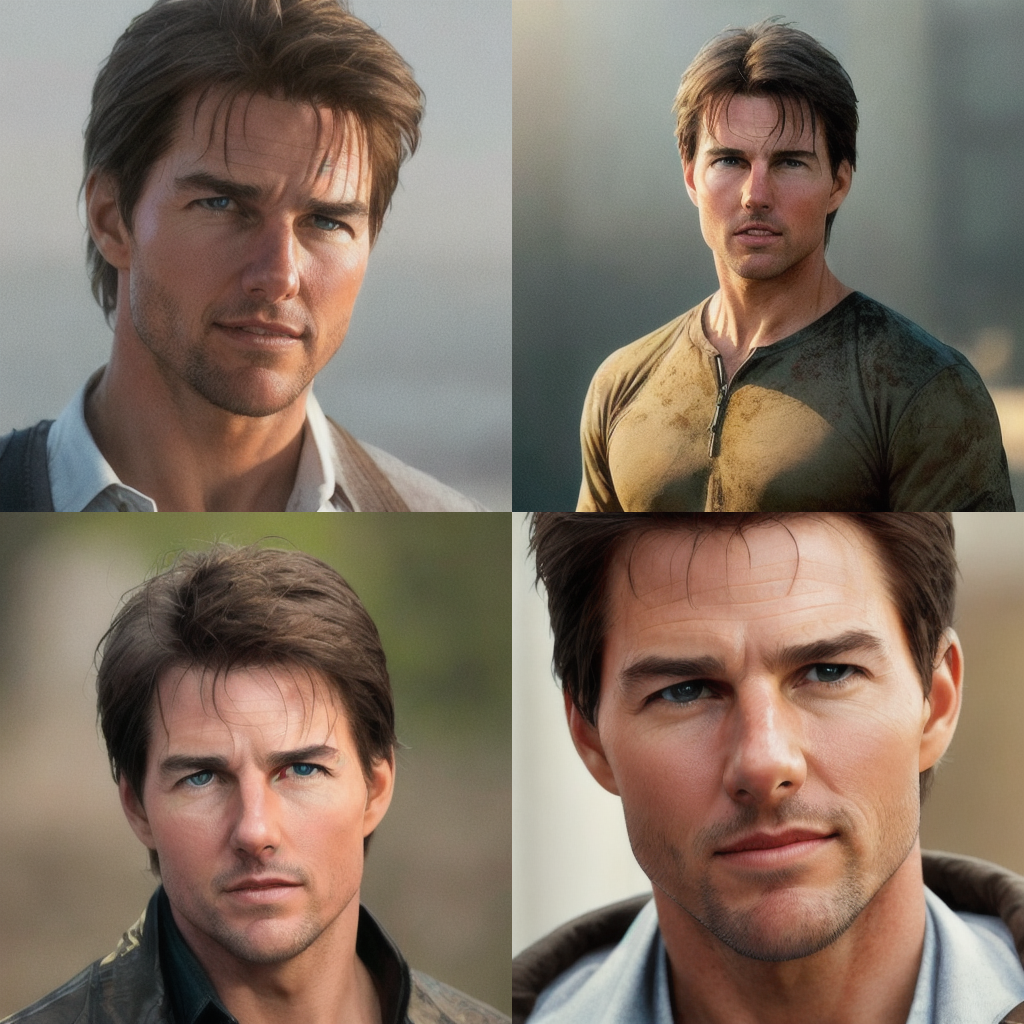

In [50]:
# @title Führe diese Zelle aus, bis dir eines der Bilder in der Grundstruktur gefällt!

# Set default parameters and UI-components
Positiver_Prompt = "a fotorealistic portrait of Tom Cruise, Movie Title Picture" #@param {type:"string"}
Negativer_Prompt = "" #@param {type:"string"}
Orientierungsskala = 3 #@param {type:"slider", min:3, max: 12, step: 0.5}
Anzahl_Inferenzschritte = 75 #@param {type:"slider", min:5, max: 150, step: 5}

# To ensure minimal quality requirements, the following lists are added at the end of every user given prompt
positive_quality_insurance_keywords = "High resolution, Precise focus, Well-defined details, Clean composition, Consistent lighting"
negative_quality_insurance_keywords = "duplicate, bad face, bad eyes, bad hands, bad anatomy, missing fingers, cropped, mutated hands, extra fingers, black and white, lowres, error, cropped, worst quality, low quality, jpeg artifacts, out of frame, watermark, signature"

# Set the number of images to be created
num_images = 4

# Concatenate the user given prompts with the quality insurance prompts
# then duplicate them, so the required number of images is matched with the number of prompts
concatenated_prompt = [f"{Positiver_Prompt}, {positive_quality_insurance_keywords}"] * num_images
concatenated_negative_prompt = [f"{Negativer_Prompt}, {negative_quality_insurance_keywords}"] * num_images

# PIL provides basic utilities to work with Images
from PIL import Image

# Create an NxN grid, so NxN pictures are created in one execution
def image_grid(imgs, rows, cols):
    assert len(imgs) == rows*cols

    w, h = imgs[0].size
    grid = Image.new('RGB', size=(cols*w, rows*h))
    grid_w, grid_h = grid.size

    for i, img in enumerate(imgs):
        grid.paste(img, box=(i%cols*w, i//cols*h))
    return grid

# adjust height and width to match the number of generated images
height = pipe.unet.config.sample_size * pipe.vae_scale_factor
width = pipe.unet.config.sample_size * pipe.vae_scale_factor

# function to disable safety checker (black images)
def disabled_safety_checker(images, clip_input):
  if len(images.shape)==4:
      num_images = images.shape[0]
      return images, [False]*num_images
  else:
      return images, False
# optionally disable safety_checker (preferably only allow for this, if the students accidentally run into black images, or receive false positives)
# pipe.safety_checker = disabled_safety_checker

# setup for the random number generator, to build seeds for deterministic execution
device = "cuda"
generator = torch.Generator(device=device)

# Prepare pipeline, grid and unique seeds for the required number of images
latents = None
seeds = []
for _ in range(num_images):
    # Get a new random seed, store it and use it as the generator state
    seed = generator.seed()
    seeds.append(seed)
    generator = generator.manual_seed(seed)

    # Generate seeded latent representation of the "starting image"
    image_latents = torch.randn(
        (1, pipe.unet.in_channels, height // 8, width // 8),
        generator = generator,
        device = device
    )
    latents = image_latents if latents is None else torch.cat((latents, image_latents))

# latents should have shape (4, 4, 64, 64) in this case
# latents.shape

# [concatenated_prompt] * num_images,
# [concatenated_negative_prompt] * num_images,

# Generate and show images with the seeded latents for deterministic behavior
with torch.autocast(device):
    images = pipe(
        prompt=concatenated_prompt,
        negative_prompt=concatenated_negative_prompt,
        num_inference_steps=Anzahl_Inferenzschritte,
        guidance_scale=Orientierungsskala,
        latents = latents
    )["images"]

# display the images in a grid
image_grid(images, 2, 2)

## Bildanpassung

In der nächsten Codezelle kannst du das Bild auswählen, welches dir am besten gefallen hat und "Positive" und "Negative" Ergänzungen in deinen Prompts vornehmen.

### Hinweis 1:
****
Du kannst eines der obigen Bilder wählen, um es weiter zu bearbeiten, indem du die Position des Bildes für den Parameter "selected_image" angibst:
<br>1 &emsp; 2
<br>3 &emsp; 4

Alternativ kannst du ein bearbeitetes Bild auch weiter bearbeiten.
Gib dafür eine Zahl an die nicht 1, 2, 3 oder 4 ist.

  0%|          | 0/15 [00:00<?, ?it/s]

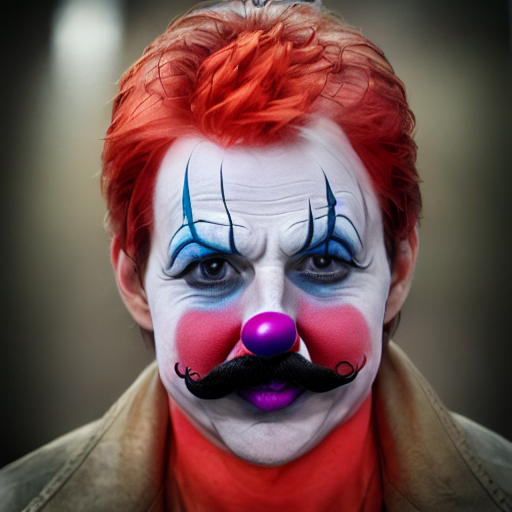

In [48]:
# @title Wähle das Bild aus, welches dir am besten gefallen hat und mache Änderungen!

# User selection of the desired image to rework
Bild = 1 # @param {type:"number"})

# Set default parameters
Positiver_Prompt = "give him an award winning big twirled mustache and put him into subtle clown makeup" # @param {type:"string"}
Negativer_Prompt = "" # @param {type:"string"}
Orientierungsskala = 1.5 #@param {type:"slider", min:1, max: 3, step: 0.5}
Anzahl_Inferenzschritte = 10 #@param {type:"slider", min:5, max: 150, step: 1}
image_index = Bild - 1

if Bild and (Bild > 0 and Bild < 5):
  image = images[image_index]
else:
  image = altered_image

altered_image = editing_pipe(
    image=image,
    num_inference_steps=Anzahl_Inferenzschritte,
    image_guidance_scale=Orientierungsskala,
    prompt = [Positiver_Prompt],
    negative_prompt = [Negativer_Prompt],
).images[0]
altered_image